# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 35.3 MB/s 

In [2]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    BitsAndBytesConfig,
)
import peft
import wandb
import evaluate

In [3]:
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

# <font color = 'indianred'> **2. Load_Dataset** </font>

In [4]:
!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

In [5]:
emotion_data = load_dataset('Praful659/train_emotion_spring_2024')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6179 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [6]:
print(type(emotion_data))

<class 'datasets.dataset_dict.DatasetDict'>


In [7]:
emotion_data['train'][0:2]

{'text': ['Does anyone know, are both Sims in a dual sim phone both locked to the same network! #worry',
  'A not very young man compiled info on a smiling baby then a mattress created new evil.'],
 'label': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

In [8]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

# <font color = 'indianred'>**3. Load pre-trained Tokenizer**</font>



In [9]:
checkpoint = "intfloat/e5-mistral-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/981 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [10]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

In [11]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [12]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})

#  <font color = 'indianred'> **4. Model Training**

##  <font color = 'indianred'> **4.1. compute_metrics function** </font>



In [13]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Remove extra dimensions if necessary
    if len(logits.shape) > 2:
        logits = logits.squeeze()

    # Ensure predictions have the correct format (e.g., binary/multilabel)
    preds = (logits > 0).astype(int)

    # Check that the predictions and labels align in shape
    if preds.shape != labels.shape:
        raise ValueError(f"Mismatch in predictions and labels shapes: {preds.shape} vs {labels.shape}")

    # Compute metrics
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')

    return {
        'f1_micro': f1_micro['f1'],
        'f1_macro': f1_macro['f1'],
        'accuracy': accuracy['accuracy'],
    }


## <font color = 'indianred'> **4.2. Training Arguments**</font>







In [14]:
# Define the directory where model checkpoints will be saved
run_name = "intfloat/e5-mistral-7b-instruct"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=5,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    #gradient_accumulation_steps=4,

    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-4,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch',  # Optimizer,
    max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

     #fp16=True,
    bf16=True
    # tf32= False
)


## <font color = 'indianred'> **4.3. Specify Model**</font>

In [15]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  llm_int8_skip_modules = ['score'],
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config)

model = prepare_model_for_kbit_training(model)

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config
model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.28G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at intfloat/e5-mistral-7b-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MistralForSequenceClassification(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): M

In [17]:

model.config.pad_token_id = 2
model.config

MistralConfig {
  "_name_or_path": "intfloat/e5-mistral-7b-instruct",
  "architectures": [
    "MistralModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 2,
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_emb

## <font color = 'indianred'> **4.4. LORA Setup**</font>

In [18]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['o_proj',
 'score',
 'up_proj',
 'v_proj',
 'gate_proj',
 'k_proj',
 'q_proj',
 'down_proj']

In [19]:
LoraConfig??

In [20]:
mistral_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="lora_only",
    modules_to_save = ['score'],
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

mistral_qlora_model = get_peft_model(model, mistral_peft_config )
# mistral_qlora_model.config.pad_token_id = tokenizer.pad_token_id
# mistral_qlora_model.resize_token_embeddings(len(tokenizer))
mistral_qlora_model.print_trainable_parameters()

trainable params: 335,589,376 || all params: 7,446,294,528 || trainable%: 4.506796967781718


In [21]:
mistral_peft_config.target_modules

{'down_proj', 'gate_proj', 'k_proj', 'o_proj', 'q_proj', 'up_proj', 'v_proj'}

##  <font color = 'indianred'> **4.4 Custom Trainer**</font>



In [22]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(emotion_data)


In [23]:
pos_weights

tensor([ 1.6795,  5.9349,  1.6519,  4.7002,  1.6947,  8.4192,  2.3988,  7.6541,
         2.3400, 18.6783, 19.1928])

In [24]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [25]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [26]:
mistral_qlora_model.config

MistralConfig {
  "_name_or_path": "intfloat/e5-mistral-7b-instruct",
  "architectures": [
    "MistralModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 2,
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_emb

In [27]:
trainer = CustomTrainer(
    model=mistral_qlora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

## <font color = 'indianred'> **4.5 Setup WandB**</font>

In [28]:
wandb.login()
%env WANDB_PROJECT = emotions_kaggle_S2024

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=emotions_kaggle_S2024


## <font color = 'indianred'> **4.6. Start Training**</font>

In [87]:
!nvidia-smi

Tue May  7 22:54:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   46C    P0              27W /  72W |  10645MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [29]:
trainer.train()  # start training

wandb: Currently logged in as: prafulp659 (utd659). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
50,1.152400,0.803832,0.349348,0.101732,0.003883
100,0.805800,0.798179,0.417431,0.148510,0.012298
150,0.788200,0.749817,0.485055,0.263242,0.092557
200,0.722400,0.718802,0.519201,0.302552,0.146278
250,0.683600,0.705236,0.536816,0.330977,0.135922
300,0.676000,0.677549,0.544662,0.324760,0.121036
350,0.646800,0.671855,0.568529,0.336950,0.150162
400,0.642700,0.664439,0.567176,0.338935,0.139159
450,0.627300,0.651246,0.577648,0.397928,0.125566


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=T

TrainOutput(global_step=485, training_loss=0.7389782384498832, metrics={'train_runtime': 1311.564, 'train_samples_per_second': 23.556, 'train_steps_per_second': 0.37, 'total_flos': 7.851993074481562e+16, 'train_loss': 0.7389782384498832, 'epoch': 5.0})

## <font color = 'indianred'> **4.7. Validation**</font>


In [30]:
eval_results = trainer.evaluate(tokenized_dataset["validation"])

In [31]:
eval_results

{'eval_loss': 0.6512455940246582,
 'eval_f1_micro': 0.5776476578411405,
 'eval_f1_macro': 0.39792809081803515,
 'eval_accuracy': 0.1255663430420712,
 'eval_runtime': 15.0108,
 'eval_samples_per_second': 102.926,
 'eval_steps_per_second': 1.665,
 'epoch': 5.0}

In [32]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [33]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["validation"])

In [34]:
valid_output.predictions.shape

(1545, 11)

In [35]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

In [36]:
predictions_valid.shape

(1545, 11)

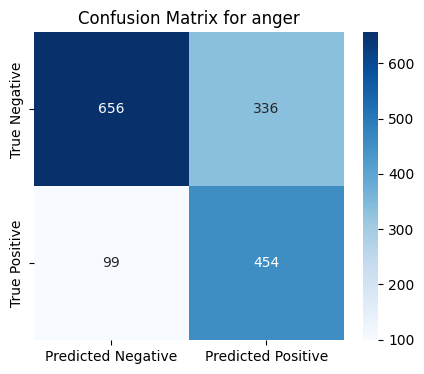

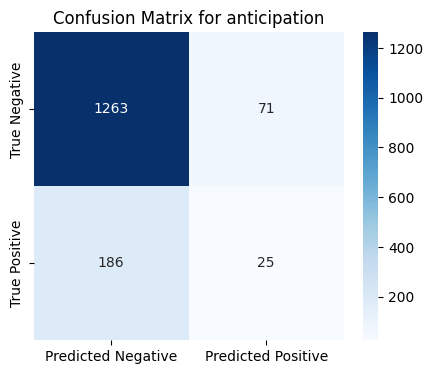

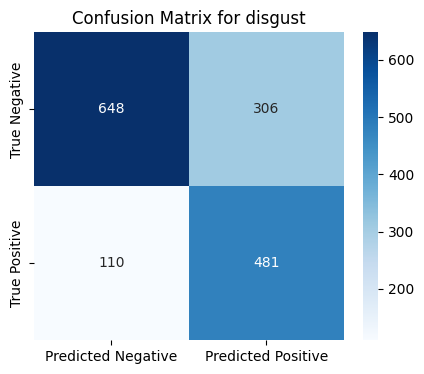

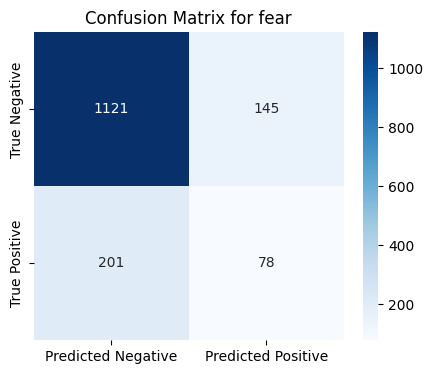

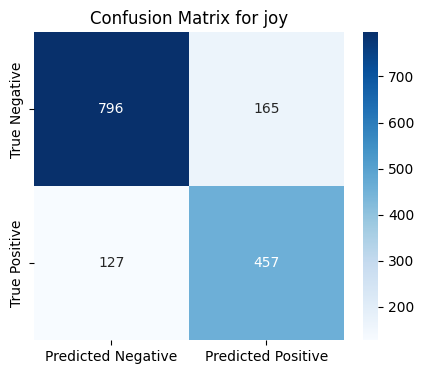

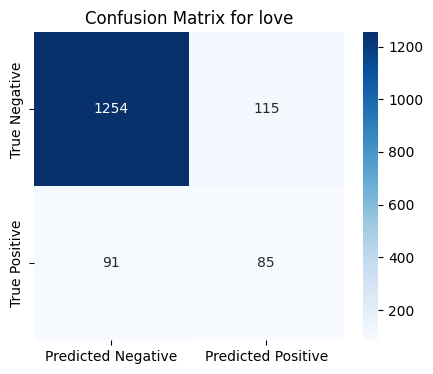

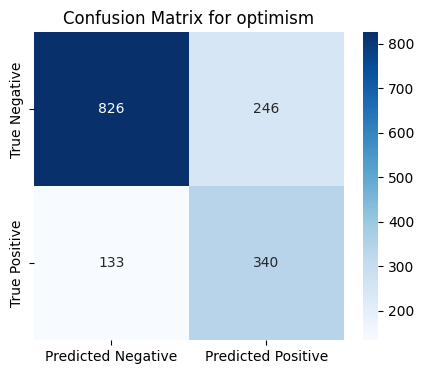

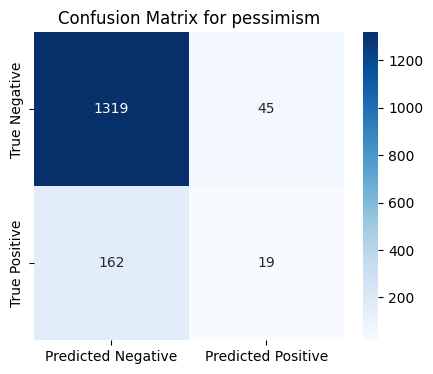

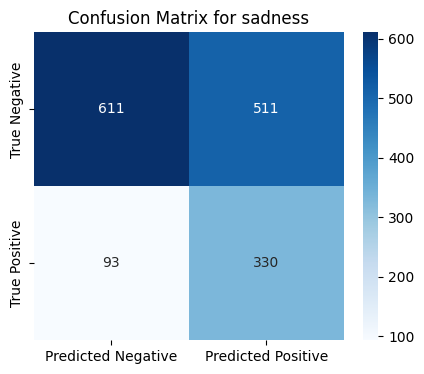

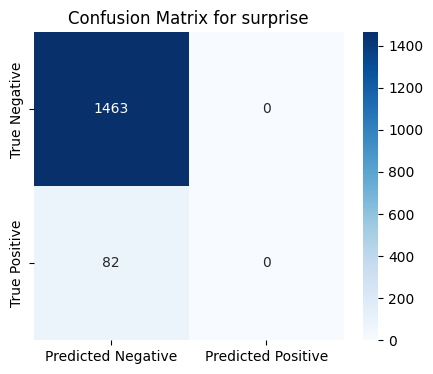

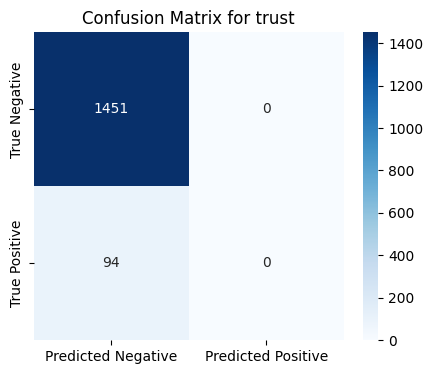

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


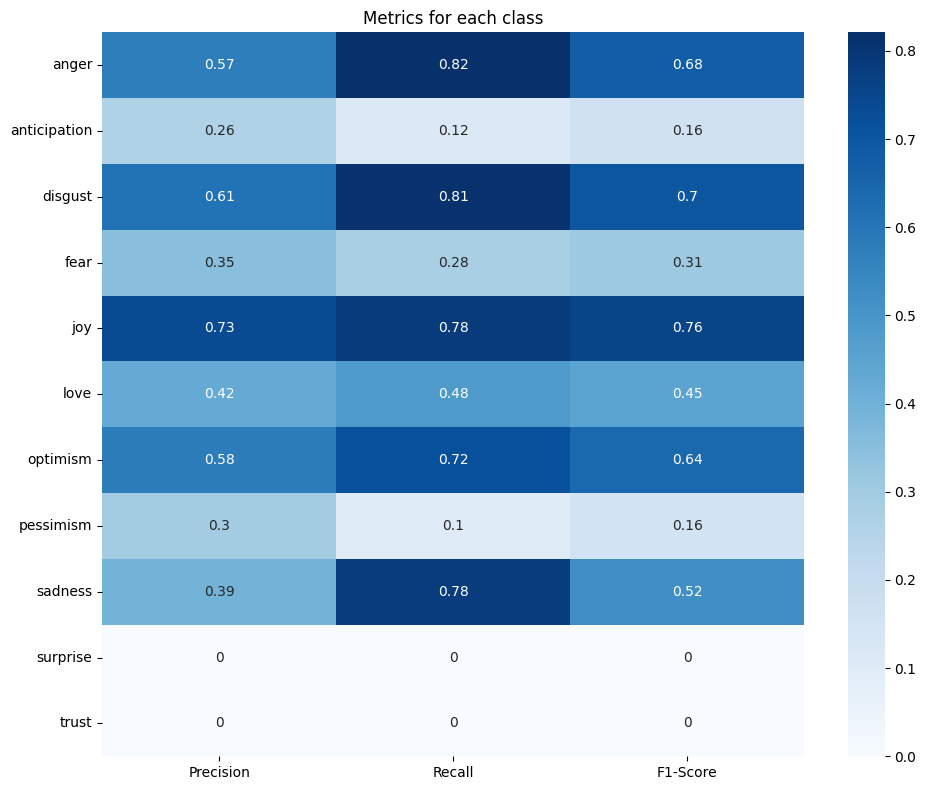

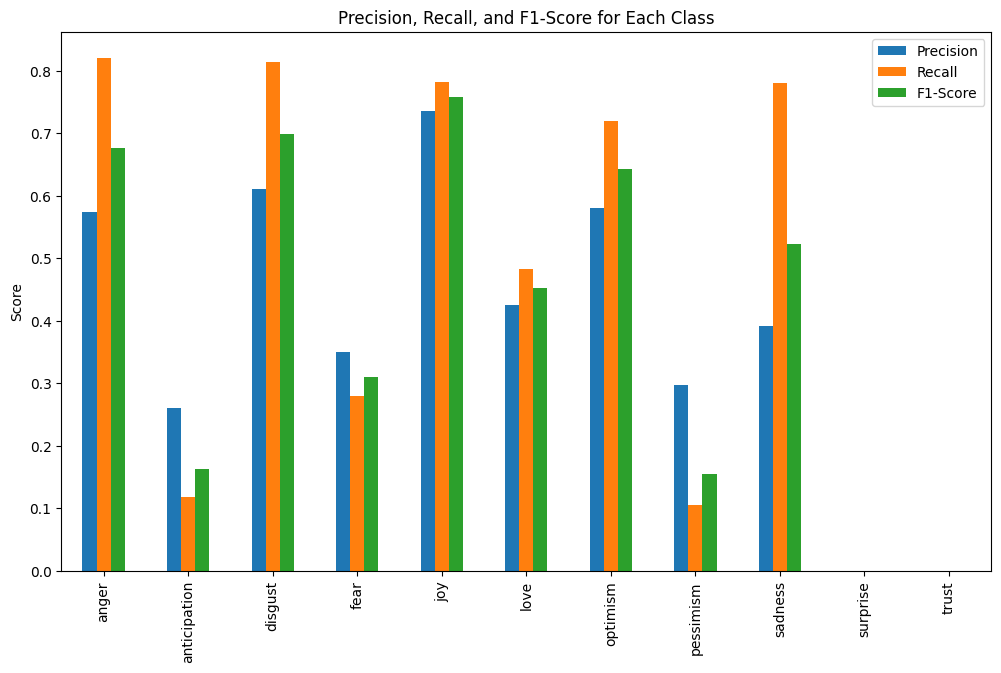

In [37]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()




In [38]:
wandb.finish()

eval/accuracy,▁▁▅█▇▇█▇▇▇
eval/f1_macro,▁▂▅▆▆▆▇▇██
eval/f1_micro,▁▃▅▆▇▇████
eval/loss,██▆▄▃▂▂▂▁▁
eval/runtime,▅▃▆▂▁▂▁▃▃█
eval/samples_per_second,▄▆▃▇█▇█▆▆▁
eval/steps_per_second,▄▅▄▇▇▇█▇▇▁
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


In [40]:
mistral_qlora_model.push_to_hub("Praful659/e5-mistral-7b-instruct_QLoRA_model_emotion_detection")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Praful659/e5-mistral-7b-instruct_QLoRA_model_emotion_detection/commit/cf2d6c926ca19230c3cc91adf31a94617f8687ea', commit_message='Upload model', commit_description='', oid='cf2d6c926ca19230c3cc91adf31a94617f8687ea', pr_url=None, pr_revision=None, pr_num=None)

# Test Set Predictions

In [41]:
!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

In [43]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer

peft_model_id = "Praful659/e5-mistral-7b-instruct_QLoRA_model_emotion_detection"
config = PeftConfig.from_pretrained(peft_model_id)
config.base_model_name_or_path
base_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path,
                                                                num_labels=11,
                                                                problem_type="multi_label_classification")
                                                                #quantization_config=bnb_config)

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at intfloat/e5-mistral-7b-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
base_model

MistralForSequenceClassification(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    

In [45]:
# Load the Lora model
inference_model = PeftModel.from_pretrained(base_model, peft_model_id)

adapter_model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [46]:
inference_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): MistralForSequenceClassification(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=2)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Line

In [48]:
test_df = pd.read_csv("/content/drive/MyDrive/NLP/HW_7/test.csv")

In [49]:
from datasets import Dataset
# 1. Define features for test data
X_test = test_df['Tweet'].tolist()

# 2. Ensure label columns are similar to training data
labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

test_df[labels] = test_df[labels].replace('NONE', 0).to_numpy(dtype=np.int64)

# Convert label columns to int type
test_df[labels] = test_df[labels].astype(float)

# Create Dataset object for test set
testset = Dataset.from_dict({
    'text': X_test,
    'labels': test_df[labels].values.tolist()
})

# 4. Verify the test set
print(testset[:5])
print(testset.features)

# Verify the type of features and labels
print(type(testset[0]['text']))
print(type(testset[0]['labels']))

{'text': ['@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell', 'Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation', 'I blew that opportunity -__- #mad', 'This time in 2 weeks I will be 30... 😥', '#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse'], 'labels': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}
{'text': Value(dtype='string', id=None), 'labels': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}
<class 'str'>
<class 'list'>


In [50]:
# Preprocess test data
X_test = test_df['Tweet'].tolist()

# Replace 'NONE' with 0 in the label columns
labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
test_df[labels] = test_df[labels].replace('NONE', 0).to_numpy(dtype=np.int64)


In [51]:
# Convert label columns to int type
test_df[labels] = test_df[labels].astype(float)

# Create Dataset object for test set
testset = Dataset.from_dict({
    'text': X_test,
    'labels': test_df[labels].values.tolist()
})


In [52]:
testset

Dataset({
    features: ['text', 'labels'],
    num_rows: 3259
})

In [53]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

In [54]:
tokenized_dataset= testset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [55]:
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)

In [56]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss

def compute_metrics_test(eval_pred):
    logits, labels = eval_pred
    # Apply sigmoid to the logits to get probabilities
    probabilities = 1 / (1 + np.exp(-logits))
    # Choosing appropriate threshold and converting into predictions
    predictions = (probabilities >= 0.46).astype(int)
    #print(np.average(probabilities))

    # Metrics calculation
    accuracy = accuracy_score(labels.flatten(), predictions.flatten())
    f1 = f1_score(labels, predictions, average='macro', zero_division=0)
    precision = precision_score(labels, predictions, average='macro', zero_division=0)
    recall = recall_score(labels, predictions, average='macro', zero_division=0)
    hamming = hamming_loss(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hamming_loss': hamming,
#Returining Predictions from here to create the datafarme later
        'predictions': predictions
    }


In [57]:
tokenized_dataset

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 3259
})

In [58]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=4,
    do_train=False,
    do_eval=False,
    remove_unused_columns=False,
    report_to=[]
)

In [59]:
# Create the trainer instance
trainer = Trainer(
    model=inference_model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_test,
)

In [60]:
# Make predictions on the test dataset
predictions = trainer.predict(tokenized_dataset)


In [61]:
predictions.metrics['test_predictions']

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 1, 0, 0]])

#creating submission file

In [62]:
predicted_labels = predictions.metrics['test_predictions']

test_ids = test_df['ID']

label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
                 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

predictions_df = pd.DataFrame(predicted_labels, columns=label_columns)

predictions_df.insert(0, 'ID', test_ids)

predictions_df

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,0,1,0,0,1,0,1,0,0,0,0
1,2018-03739,0,0,0,0,1,0,0,0,1,0,0
2,2018-00385,0,0,0,1,0,0,0,1,1,0,0
3,2018-03001,0,0,0,0,0,0,0,0,1,0,0
4,2018-01988,0,0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,1,0,1,0,0,0,0,0,1,0,0
3255,2018-00416,0,1,0,0,1,0,1,0,0,0,0
3256,2018-03717,1,0,1,0,0,0,0,0,0,0,0
3257,2018-03504,0,0,0,0,1,0,1,0,0,0,0


In [64]:
predictions_df.to_csv('output_e5-mistral-7b-instruct_QLoRA.csv', index=False)